In [1]:
# Main file funcitons
from configs import *

# Main manipulation functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.base import  clone
from sklearn.model_selection import  cross_val_score, cross_val_predict
from sklearn.metrics import  confusion_matrix, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
%matplotlib inline

In [2]:
titanic_train_data = pd.read_excel("train.xlsx")
titanic_test_data = pd.read_excel("test.xlsx")
titanic_train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
# PassengerId is like acounter column so we need to drop it
titanic_train_data = titanic_train_data.drop(columns=['PassengerId'])
titanic_test_data  = titanic_test_data.drop(columns=['PassengerId'])

titanic_train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Info Method

As we are just displaying the data but some things we can notice from this display like **Nan** values, some of the data are numbers, others are object string, to go forward of other information about the total memory that the data used, or the data type for each feature and which is it contains **Nan** values or not and other information about the data we can use the **info** method associated with the pandas data frame.

In [53]:
titanic_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


We have 4 integers, 5 objects, 2 float columns, and have 891 instance, but as we can see some features have Nan and  The memory usage can fit easily .



From what we have see from the **info** method, it will be useful to make a pipeline for each of these data, like pipeline handle **numbers**, others for **category** and at the end, we need to combine these two pipelines together.


In [54]:
titanic_train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Describe method working with numeric data, it provide you with some of statics about the feautres(columns data) you have,it work only on the existing values so nan values are ignored, it help you in like that:

- 25% of people in the dataset we have their age is smaller than 21 years.
- it help you also to know which max of each features, which help you to know if you need feature scaling.

As we can see the data have different forms, numbers, and categories, so what we need is to handle these things separately and in the end, we can combine them in one pipeline.

We will start with the numeric data, spend some time in the analysis of these numbers.
Maybe some numerical data are actually categorical like the target **Survived**, they represent classes.

In [55]:
titanic_train_data[['SibSp', 'Parch', 'Pclass']].isnull().sum()

SibSp     0
Parch     0
Pclass    0
dtype: int64

In [56]:
titanic_train_data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [57]:
titanic_train_data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

# Pclass 
Ticket class is the level(class) of each passenger on the ship.

In [58]:
titanic_train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

# Numerical Analysis

So at the beginning we represent the info method which give us conclusion about each column, then we have see that, there are 4 integer and 2 float point numbers, exclude the **Survived** column which our predicted variable, so we have 3 integer and 2 float numbers.

After some of representations of values_count asscoiated with each of integer variable, we can get some information.

Either [sibsp, parch, class] although are actually integer, but in some way they are actually categorical variables, and the order of each of these are meaningful, like those in **first class** feature maybe are likely to be survived than other, as well as people who have more siblings are likely to help each other to be survived, and parents can help they child to be alive than themselves.

So, keeping these columns as the same as label encoder instead of convert to one-hot encoding like those are **Nominal categorical variable**, because the order of these variables has some implicit meaning .

**While other ones are float so we can not get more information from the value_counts method. Let's try to see the distribution of these 2 float numbers.**

In [59]:
# Age need handling of nan values.
titanic_train_data[['Age', 'Fare']].isnull().sum()

Age     177
Fare      0
dtype: int64

## Handle Age Nan values

Either mean or median give some intuitive values related to what our brain can think of, but as usuall represent with median in case of skweed data is good than mean.

In [60]:
print(titanic_train_data['Age'].mean())
print(titanic_train_data['Age'].median())

29.69911764705882
28.0


In [61]:
titanic_train_data['Age'] = titanic_train_data['Age'].fillna(titanic_train_data['Age'].median())

# Now Age nan values are handled
titanic_train_data[['Age', 'Fare']].isnull().sum()

Age     0
Fare    0
dtype: int64

## Age & Fare

**Lets check the distribution shape to know if there are outliers that we can handle.**

array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'Fare'}>]], dtype=object)

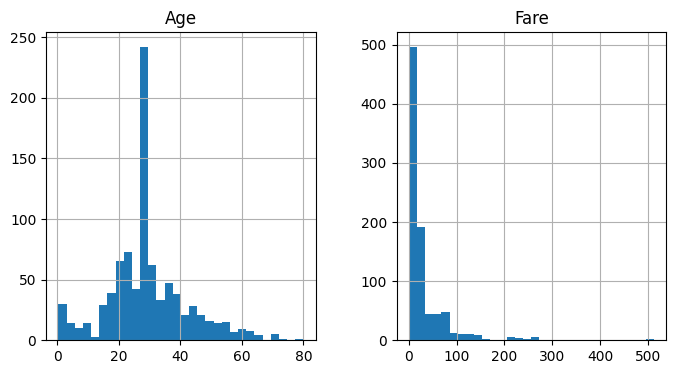

In [62]:
titanic_train_data[['Age', 'Fare']].hist(bins=30, figsize=(8,4))

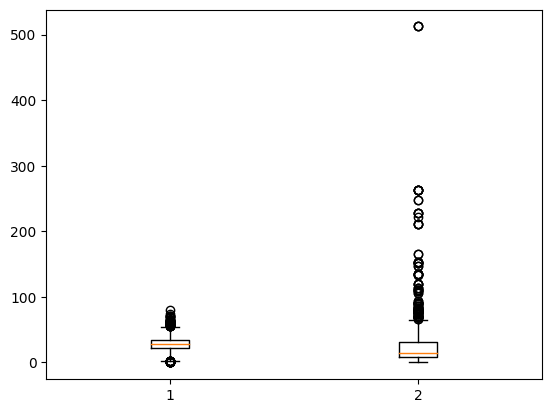

<Figure size 1000x1000 with 0 Axes>

In [63]:
plt.boxplot(titanic_train_data[['Age', 'Fare']])
fig = plt.figure(figsize =(10, 10))
plt.show()

### as we see from the above boxplot there are some outliers after scaling.

In [64]:
def log_scale_to_handle_outliers(data, list_of_cols, method='box-cox'):
    pt = preprocessing.PowerTransformer(method=method, standardize=False)
    log_scale = pt.fit_transform(data[list_of_cols])

    log_scale = pd.DataFrame(log_scale, columns=list_of_cols)


    return log_scale

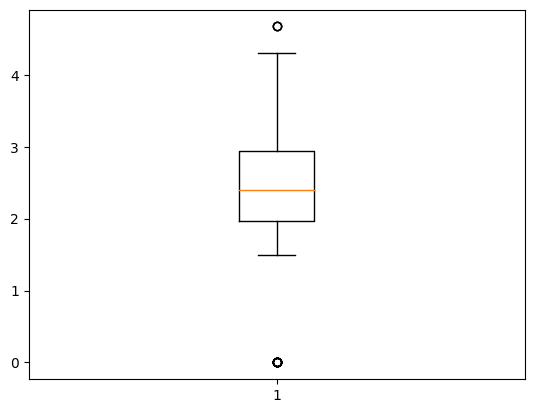

<Figure size 1000x1000 with 0 Axes>

In [65]:
log_scale = log_scale_to_handle_outliers(titanic_train_data, ['Fare'], 'yeo-johnson')
plt.boxplot(log_scale['Fare'])
fig = plt.figure(figsize =(10, 10))
plt.show()

### this is outlier in fare which was fewer than the outlier of age after scaling

## From Scaling

We can see that scaling the Age increase the outliers while its decrease lots in Fare so replace the scaled Fare column and keep the Age, to be handled later.

In [66]:
titanic_train_data['Fare'] = log_scale['Fare']

In [67]:
titanic_train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,2.537799
std,0.486592,0.836071,13.019697,1.102743,0.806057,0.718497
min,0.000000,1.000000,0.420000,0.000000,0.000000,-0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,1.969136
50%,0.000000,3.000000,28.000000,0.000000,0.000000,2.402006
75%,1.000000,3.000000,35.000000,1.000000,0.000000,2.939543
max,1.000000,3.000000,80.000000,8.000000,6.000000,4.671393


In [68]:
titanic_train_data['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [69]:
titanic_train_data['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [70]:
titanic_train_data.drop(['Ticket', 'Cabin', 'Name'], axis=1, inplace=True)
titanic_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,1.906724,S
1,1,1,female,38.0,1,0,3.497640,C
2,1,3,female,26.0,0,0,1.970459,S
3,1,1,female,35.0,1,0,3.304258,S
4,0,3,male,35.0,0,0,1.981680,S


In [71]:
titanic_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


## Last check

Now most of numerical data are handled, and we have drop columns that seems has no information, let check the last two categroical ones ["embarked", "sex"].



In [72]:
titanic_train_data[['Embarked', 'Sex']].isnull().sum()

Embarked    2
Sex         0
dtype: int64

In [73]:
titanic_train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [74]:
titanic_train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [75]:
Embarked_mode = titanic_train_data['Embarked'].mode()[0]
Embarked_mode

'S'

In [76]:
# lets fill nan by mode, because its categorical variable
titanic_train_data['Embarked'] = titanic_train_data['Embarked'].fillna(Embarked_mode)
titanic_train_data[['Embarked', 'Sex']].isnull().sum()

Embarked    0
Sex         0
dtype: int64

## Test Data
Lets do same staff for test data.

In [77]:
titanic_test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [78]:
titanic_test_data.drop(['Ticket', 'Cabin', 'Name'], axis=1, inplace=True)
titanic_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [79]:
len(titanic_test_data)

418

In [80]:
# Now Age nan values are handled
titanic_test_data[['Age', 'Fare']].isnull().sum()

Age     86
Fare     1
dtype: int64

In [81]:
titanic_test_data['Age'] = titanic_test_data['Age'].fillna(titanic_test_data['Age'].median())
titanic_test_data['Fare'] = titanic_test_data['Fare'].fillna(titanic_test_data['Fare'].median())

# Now Age nan values are handled
titanic_test_data[['Age', 'Fare']].isnull().sum()

Age     0
Fare    0
dtype: int64

In [82]:
titanic_test_data[['Embarked', 'Sex']].isnull().sum()

Embarked    0
Sex         0
dtype: int64

# Note 

As we can see people in first class are more survived than others in other classes, and also female are more survived than mailss

In [83]:
titanic_train_data[['Pclass', 'Survived']].groupby(['Pclass'], 
                                         as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [84]:
titanic_train_data[['Sex', 'Survived']].groupby(['Sex'], 
                                         as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [85]:
titanic_train_data[['SibSp', 'Survived']].groupby(['SibSp'], 
                                         as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [86]:
titanic_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [87]:
def split_data(features_based, data):

    split = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=42)
    for train_indeces, test_indeces in split.split(data, data[features_based]):
        train_data = data.iloc[train_indeces]
        test_data = data.iloc[test_indeces]

    return train_data, test_data

In [88]:
train_data, validation_data = split_data("Survived", titanic_train_data)
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
692,1,3,male,28.0,0,0,3.345343,S
481,0,2,male,28.0,0,0,-0.000000,S
527,0,1,male,28.0,0,0,4.198946,S
855,1,3,female,18.0,0,1,2.089185,S
801,1,2,female,31.0,1,1,2.824144,S


In [89]:
def initializing_for_train(numerical_attr, categorical_attr):
    train_data_copy = titanic_train_data.copy()
    validation_data_copy = validation_data.copy()

    y_train   = np.array(train_data_copy['Survived'])
    train_data_copy.drop('Survived', axis=1, inplace=True)
    
    y_val   = np.array(validation_data_copy['Survived'])
    validation_data_copy.drop('Survived', axis=1, inplace=True)
    
    
    full_pipeline = ColumnTransformer([
    ('num_pipeline', MinMaxScaler(), numerical_attr),
    ('cat_pipeline', OneHotEncoder(), categorical_attr),
    ])
    

    X_train = full_pipeline.fit_transform(train_data_copy)
    X_val   = full_pipeline.fit_transform(validation_data_copy)

    print(X_train.shape)
    print(X_val.shape)
    
    return X_train, X_val, y_train, y_val


In [90]:
def predict_result(model, X,y):
    predicted = model.predict(X)
    print("Accuracy", round(f1_score(y, predicted, average='micro')*100, 2))
    print("="*50)
    print(confusion_matrix(y, predicted))
    return True

In [91]:
numerical_attr    = [ 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age']
categorical_attri = ['Sex', 'Embarked']

X_train, X_val, y_train, y_val = initializing_for_train(numerical_attr, categorical_attri)


clf_model_1 = LogisticRegression(random_state=0).fit(X_train, y_train)
print("================ Train Accuracy ======================")
predict_result(clf_model_1, X_train, y_train)
print("================ Validation Accuracy ======================")
predict_result(clf_model_1, X_val, y_val)

(891, 10)
(179, 10)
================ Train Accuracy ======================
Accuracy 80.02
[[470  79]
 [ 99 243]]
================ Validation Accuracy ======================
Accuracy 81.01
[[100  10]
 [ 24  45]]


True

In [92]:
titanic_train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,1.906724,S
1,1,1,female,38.0,1,0,3.497640,C
2,1,3,female,26.0,0,0,1.970459,S
3,1,1,female,35.0,1,0,3.304258,S
4,0,3,male,35.0,0,0,1.981680,S


In [93]:
numerical_attr    = [ 'Pclass', 'SibSp', 'Parch', 'Fare', 'Age']
categorical_attri = ['Sex', 'Embarked']

# y_train = np.c_[y_train , y_val]
print(y_train.shape)
titanic_train_data.drop(['Survived'], axis=1, inplace=True)


# X_train, X_val, y_train, y_val = initializing_for_train(numerical_attr, categorical_attri)



full_pipeline = ColumnTransformer([
('num_pipeline', MinMaxScaler(), numerical_attr),
('cat_pipeline', OneHotEncoder(), categorical_attri),
])


X_train = full_pipeline.fit_transform(titanic_train_data)
X_test   = full_pipeline.fit_transform(titanic_test_data)


clf_model_1 = LogisticRegression(random_state=0).fit(X_train, y_train)
print("================ Train Accuracy ======================")
predict_result(clf_model_1, X_train, y_train)

(891,)
================ Train Accuracy ======================
Accuracy 80.02
[[470  79]
 [ 99 243]]


True

In [94]:
predicted = clf_model_1.predict(X_test)
predicted[:5]

array([0, 0, 0, 0, 0], dtype=int64)

In [95]:
titanic_test_data['Survived'] = predicted
titanic_test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,34.5,0,0,7.8292,Q,0
1,3,female,47.0,1,0,7.0000,S,0
2,2,male,62.0,0,0,9.6875,Q,0
3,3,male,27.0,0,0,8.6625,S,0
4,3,female,22.0,1,1,12.2875,S,0


In [96]:
predicted[:100]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int64)